# Capstone Milestone #2 - Sam Chakerian

## Original ideas
My original capstone ideas were nutritional analysis of Instacart orders, predicting solar output from satellite imaging, and identifying fake news. Of those I chose predicting solar output from satellite imaging, because it had the best balance of challenge and reasonableness.

## Main goal
The goal of the project is to predict daily, weekly, and monthly solar irradiance levels using historical data.

## Methods and models
I will use historical irradiance data to build a time series model. I will use alternative datasets (weather and satellite) as available to improve my modeling.

There are three types of irradiance metrics:

- Direct Normal Irradiance (DNI) is the amount of radiation recieved by a surface held perpendicular to the rays.
- Diffuse Horizontal Irradiance (DHI) is the amount of radiation recieved that does not arrive at a direct path from the sun (i.e. diffusion from clouds).
- Global Horizontal Irradiance (GHI) is the amount of shortwave radiation recieved by a surface horizontal to the ground.

## Risks and assumptions
I assume the data from my sources ([SolarAnywhere](https://www.solaranywhere.com/), [NREL](https://www.nrel.gov/grid/solar-resource/renewable-resource-data.html)) is accurate. 

## Goals and success 
The goal is to predict daily, weekly, and monthly irradiance values for the Los Angeles area. The predicted metrics will be DNI, DHI, and GHI. The accuracy metric will be RMSE.

## Data source
I will use data from [SolarAnywhere](https://www.solaranywhere.com/) using their academic license, and [NREL](https://www.nrel.gov/grid/solar-resource/renewable-resource-data.html). Specifically NREL lists the [LMU solar resource program](https://midcdmz.nrel.gov/apps/go2url.pl?site=LMU#DOI) website as a data source.

I will also use alternative data sources (weather and satellite) as available.

## EDA



In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib

# Settings for plots
matplotlib.rcParams['figure.figsize'] = (13, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

### Dataset #1: SolarAnywhere, LA (2013-2014)

In [31]:
data = pd.read_csv('./solaranywhere_data.csv', encoding='unicode_escape')

# Munging
data.columns=data.iloc[0, :]
data = data.iloc[1:, :]

/Users/sam/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# Convert as much as possible to numeric
for x in data.columns:
    try:
        data[x] = pd.to_numeric(data[x])
    except:
        print('Could not convert to numeric: ' + x)

Could not convert to numeric: Date (MM/DD/YYYY)
Could not convert to numeric: Time (HH:MM)


In [19]:
# Set datetime index
for i in data.index:
    data.loc[i, 'date'] = pd.to_datetime(data.loc[i, 'Date (MM/DD/YYYY)'] + ' ' + data.loc[i, 'Time (HH:MM)'])
data.set_index('date', inplace=True)

In [20]:
# Basic description
round(data.describe(), 2)

,ETR (W/m^2),ETRN (W/m^2),GHI (W/m^2),GHI source,GHI uncert (%),DNI (W/m^2)),DNI source,DNI uncert (%),DHI (W/m^2),DHI source,...,AOD (unitless),AOD source,AOD uncert (code),Alb (unitless),Alb source,Alb uncert (code),Lprecip depth (mm),Lprecip quantity (hr),Lprecip source,Lprecip uncert (code)
count,0.0,0.0,8760.00,8760.0,0.0,8760.00,8760.0,0.0,8760.00,8760.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,221.42,2.0,NaN,241.47,2.0,NaN,70.76,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,304.49,0.0,NaN,324.17,0.0,NaN,85.27,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.00,2.0,NaN,0.00,2.0,NaN,0.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.00,2.0,NaN,0.00,2.0,NaN,0.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,20.00,2.0,NaN,0.00,2.0,NaN,20.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,420.00,2.0,NaN,561.25,2.0,NaN,134.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,1013.00,2.0,NaN,924.00,2.0,NaN,441.00,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Null values
data.isnull().sum()

0
Date (MM/DD/YYYY)             0
Time (HH:MM)                  0
ETR (W/m^2)                8760
ETRN (W/m^2)               8760
GHI (W/m^2)                   0
GHI source                    0
GHI uncert (%)             8760
DNI (W/m^2))                  0
DNI source                    0
DNI uncert (%)             8760
DHI (W/m^2)                   0
DHI source                    0
DHI uncert (%)             8760
GH illum (lx)              8760
GH illum source            8760
Global illum uncert (%)    8760
DN illum (lx)              8760
DN illum source            8760
DN illum uncert (%)        8760
DH illum (lx)              8760
DH illum source            8760
DH illum uncert (%)        8760
Zenith lum (cd/m^2)        8760
Zenith lum source          8760
Zenith lum uncert (%)      8760
TotCld (tenths)            8760
TotCld source              8760
TotCld uncert (code)       8760
OpqCld (tenths)            8760
OpqCld source              8760
                           ... 
RHum s

In [22]:
# Negative values
data[data < 0].sum()

0
Date (MM/DD/YYYY)          01/01/201301/01/201301/01/201301/01/201301/01/...
Time (HH:MM)               01:0002:0003:0004:0005:0006:0007:0008:0009:001...
ETR (W/m^2)                                                                0
ETRN (W/m^2)                                                               0
GHI (W/m^2)                                                                0
GHI source                                                                 0
GHI uncert (%)                                                             0
DNI (W/m^2))                                                               0
DNI source                                                                 0
DNI uncert (%)                                                             0
DHI (W/m^2)                                                                0
DHI source                                                                 0
DHI uncert (%)                                                            

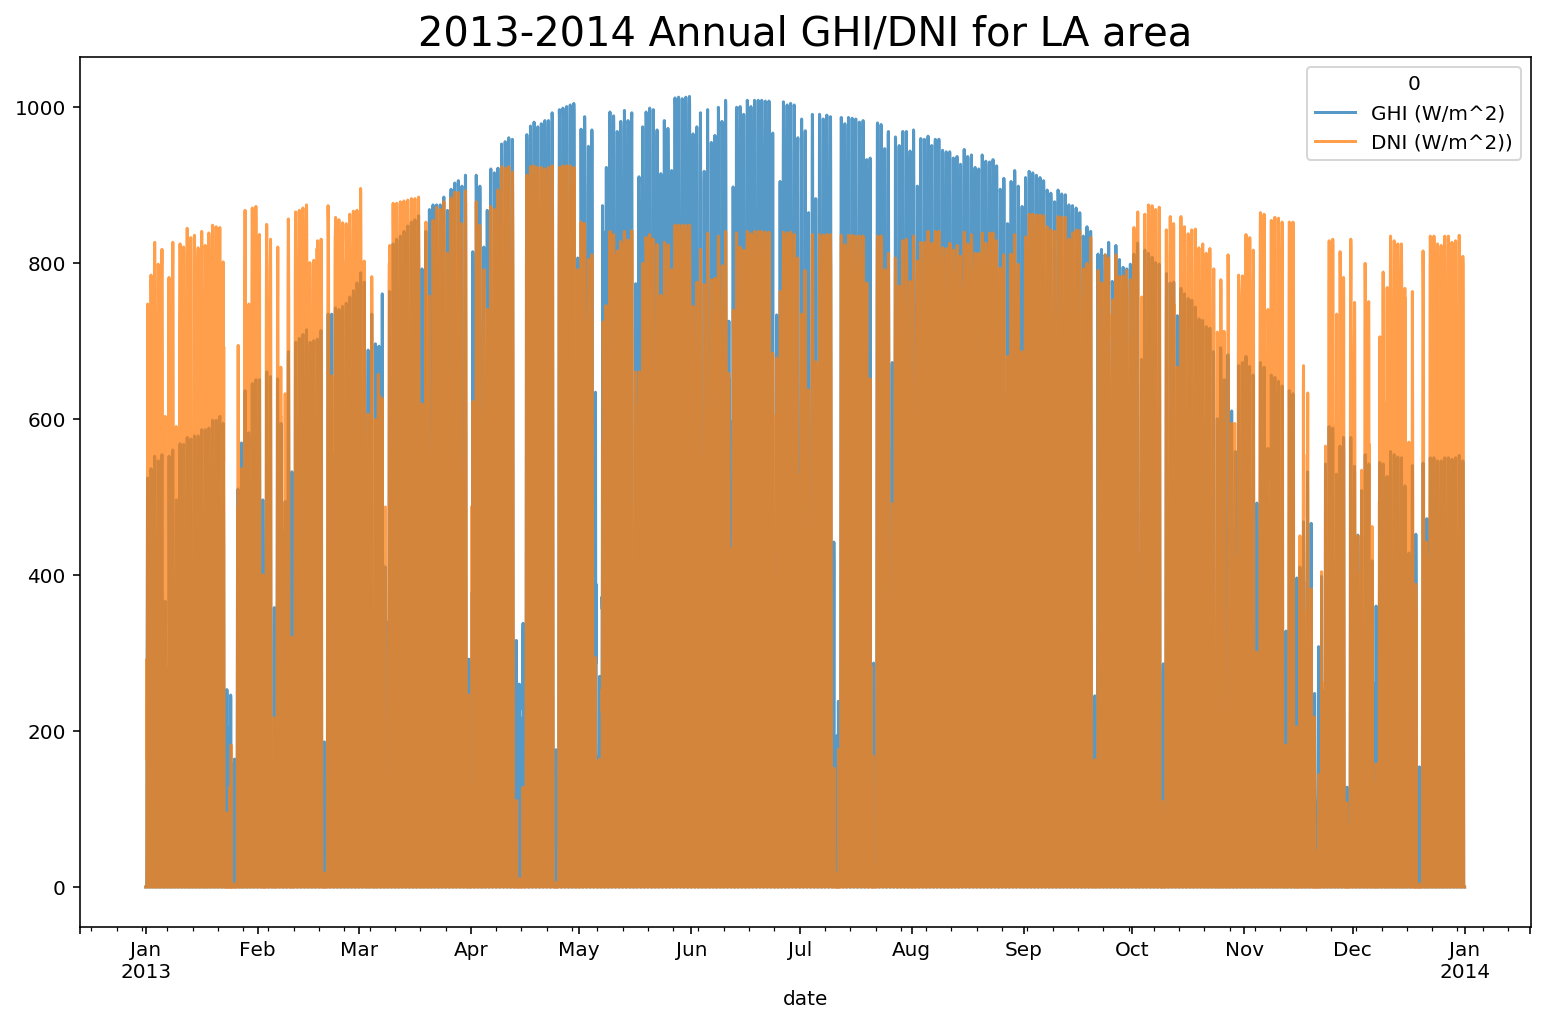

In [23]:
data[['GHI (W/m^2)', 'DNI (W/m^2))']].plot(alpha=.75)
plt.title('2013-2014 Annual GHI/DNI for LA area', fontsize=20);

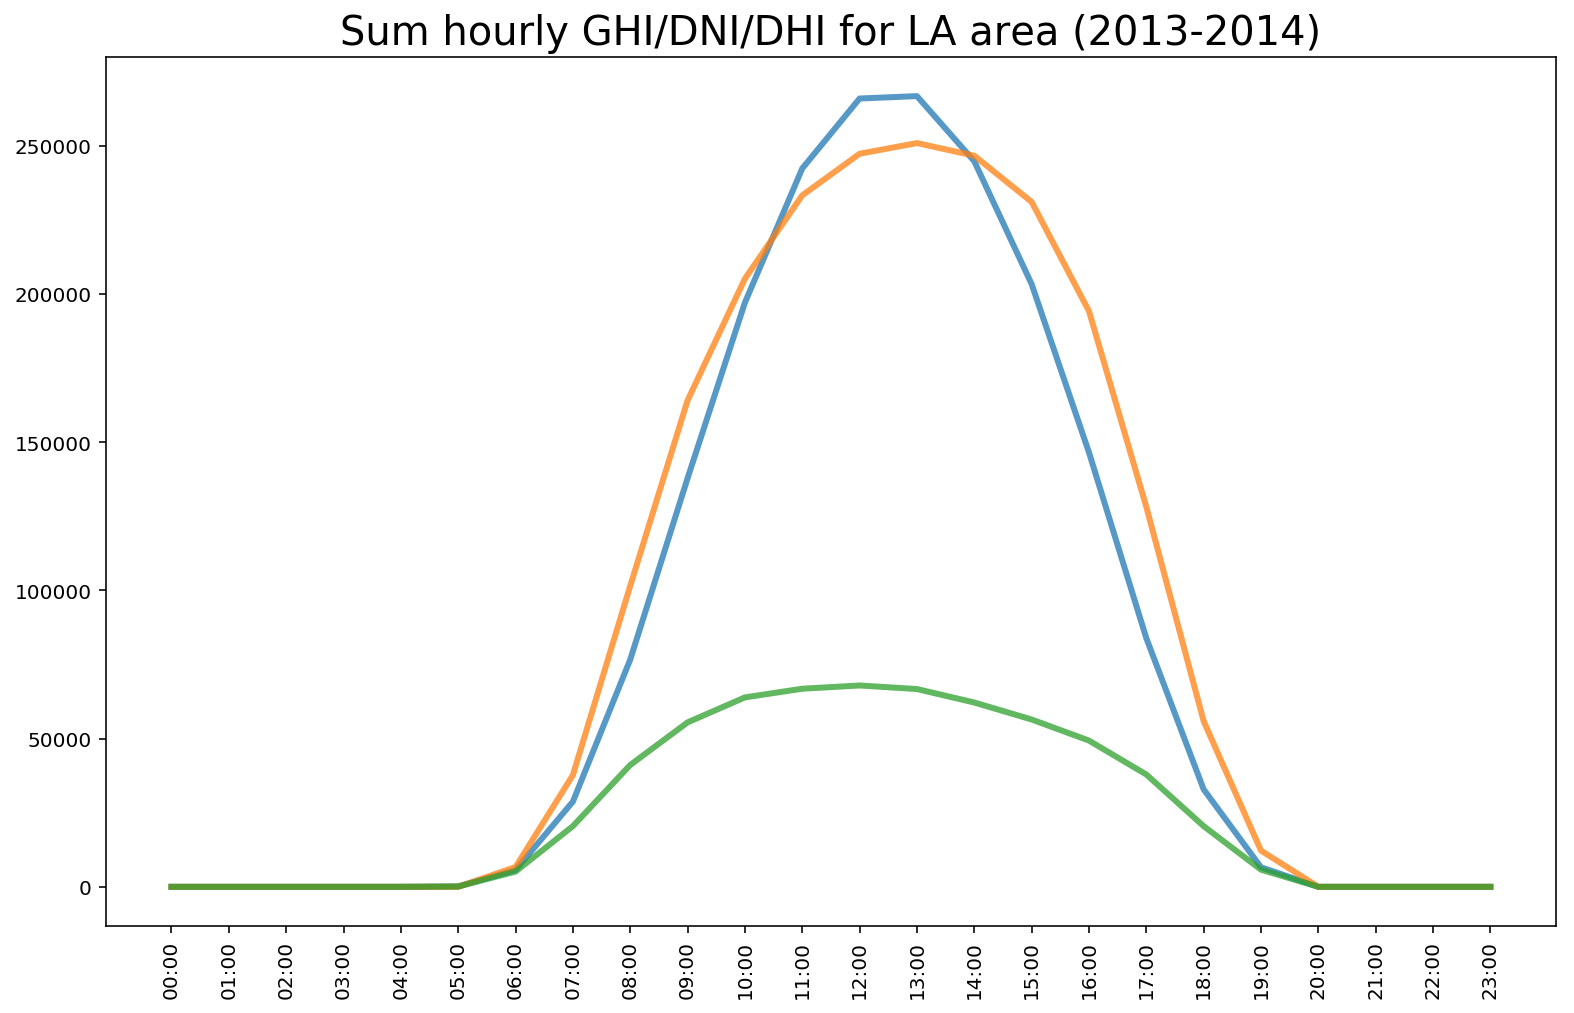

In [24]:
plt.plot(data.groupby('Time (HH:MM)').sum()[['GHI (W/m^2)', 'DNI (W/m^2))', 'DHI (W/m^2)']], lw=3, alpha=.75)
plt.title('Sum hourly GHI/DNI/DHI for LA area (2013-2014)', fontsize=20);
plt.xticks(rotation='vertical');
# plt.legend()

### Dataset #2: LMU solar dataset (2014-2015)

In [32]:
# Loyola Marymount solar data 2015-2016
data2 = pd.read_csv('./lmu_data.txt')

data2['DATE (MM/DD/YYYY)'] = pd.to_datetime(data2['DATE (MM/DD/YYYY)'])
for x in data2.index:
    data2.loc[x, 'datetime'] = data2.iloc[x, 0] + timedelta(hours=int(data2.iloc[x, 1]))
data2.set_index('datetime', inplace=True)

In [26]:
# Basic description
round(data2.describe(), 2)

,HOUR-PST,Avg Global Horizontal [W/m^2],Avg Direct Normal [W/m^2],Avg Diffuse Horizontal [W/m^2],Avg Global (secondary) [W/m^2],Avg Global (uncorrected) [W/m^2],Avg Direct (uncorrected) [W/m^2],Avg Diffuse (uncorrected) [W/m^2],Avg Air Temperature [deg C],Avg Rel Humidity [%],Avg Avg Wind Speed @ 3m [m/s],Avg Station Pressure [mBar],Avg Precipitation [mm],Avg Zenith Angle [degrees],Avg Azimuth Angle [degrees],Avg CR1000 Temp [deg C],Avg RSR Battery [VDC]
count,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00,7657.00
mean,11.71,206.08,250.97,38.46,205.44,206.96,269.12,29.80,-7.85,45.68,-24.44,984.59,-26.12,63.69,157.13,-5.73,-13.03
std,6.79,1648.25,1659.69,1619.96,1648.09,1648.52,1664.15,1619.48,1616.35,1617.34,1616.07,1632.39,1616.04,1617.99,1621.64,1616.39,1616.25
min,0.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00,-99999.00
25%,6.00,0.04,0.00,0.04,0.06,0.04,0.00,0.04,14.62,60.78,0.73,1008.25,0.00,57.43,98.31,14.69,12.81
50%,12.00,21.87,0.01,14.56,21.45,21.90,3.03,12.07,18.41,74.84,1.59,1010.48,0.00,87.50,195.27,20.21,12.95
75%,17.00,455.29,666.35,94.35,454.94,457.33,713.84,73.48,21.61,89.03,2.50,1013.75,0.00,123.58,265.96,25.57,13.53
max,23.00,1057.25,1058.44,701.57,1036.11,1047.64,1081.03,678.14,38.40,100.00,8.08,1024.50,2.67,168.02,351.33,45.36,14.24


In [27]:
# Null values
data2.isnull().sum()

DATE (MM/DD/YYYY)                    0
HOUR-PST                             0
Avg Global Horizontal [W/m^2]        0
Avg Direct Normal [W/m^2]            0
Avg Diffuse Horizontal [W/m^2]       0
Avg Global (secondary) [W/m^2]       0
Avg Global (uncorrected) [W/m^2]     0
Avg Direct (uncorrected) [W/m^2]     0
Avg Diffuse (uncorrected) [W/m^2]    0
Avg Air Temperature [deg C]          0
Avg Rel Humidity [%]                 0
Avg Avg Wind Speed @ 3m [m/s]        0
Avg Station Pressure [mBar]          0
Avg Precipitation [mm]               0
Avg Zenith Angle [degrees]           0
Avg Azimuth Angle [degrees]          0
Avg CR1000 Temp [deg C]              0
Avg RSR Battery [VDC]                0
dtype: int64

In [28]:
# Negative values
data2[data2 < 0].sum()

HOUR-PST                                  0.0000
Avg Global Horizontal [W/m^2]       -199998.0000
Avg Direct Normal [W/m^2]           -199998.0000
Avg Diffuse Horizontal [W/m^2]      -199998.0000
Avg Global (secondary) [W/m^2]      -200277.3723
Avg Global (uncorrected) [W/m^2]    -199998.0000
Avg Direct (uncorrected) [W/m^2]    -199998.0000
Avg Diffuse (uncorrected) [W/m^2]   -199998.0000
Avg Air Temperature [deg C]         -199998.0000
Avg Rel Humidity [%]                -199998.0000
Avg Avg Wind Speed @ 3m [m/s]       -199998.0000
Avg Station Pressure [mBar]         -199998.0000
Avg Precipitation [mm]              -199998.0000
Avg Zenith Angle [degrees]          -199998.0000
Avg Azimuth Angle [degrees]         -199998.0000
Avg CR1000 Temp [deg C]             -199998.0000
Avg RSR Battery [VDC]               -199998.0000
dtype: float64

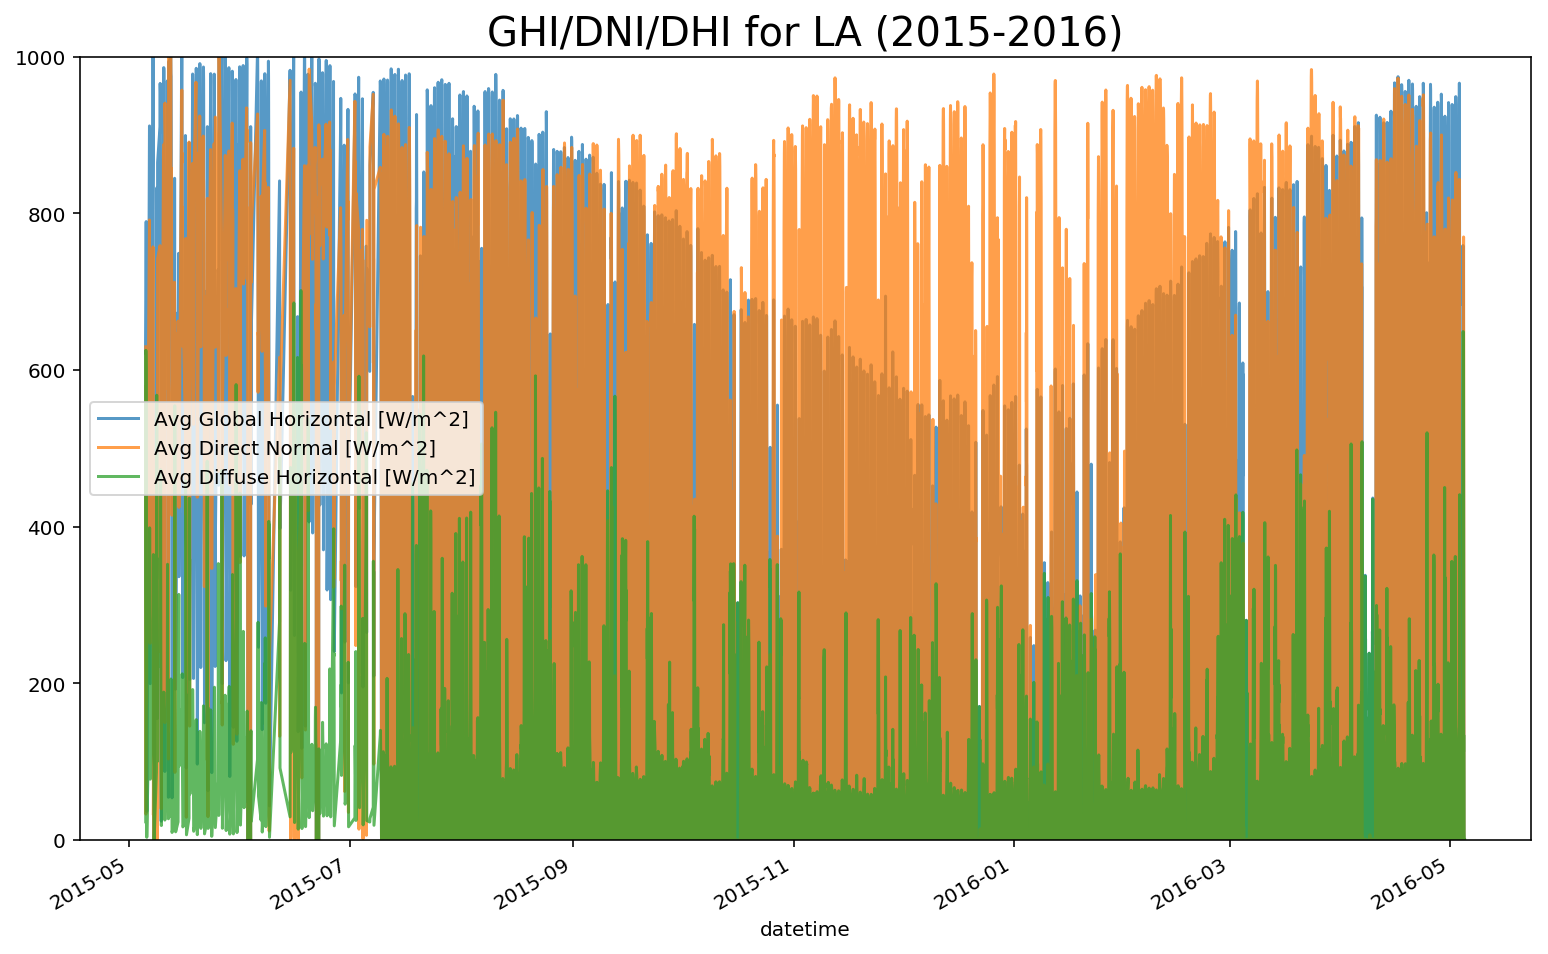

In [29]:
data2[['Avg Global Horizontal [W/m^2]', 'Avg Direct Normal [W/m^2]', 'Avg Diffuse Horizontal [W/m^2]']].plot(ylim=(0, 1000), alpha=.75)
plt.title('GHI/DNI/DHI for LA (2015-2016)', fontsize=20);

# Notes

SolarAnywhere's academic license has data for any area, but only in 10km resolution for the year of 2013.

From NREL, LMU SOLRMAP program's website has raw data for the LA area from April 06, 2010 to May 05, 2016.